# Coursework: Masked Auto-Encoder

In this coursework, you will explore the popular self-supervised masked auto-encoder approach [MAE](https://arxiv.org/pdf/2111.06377v2).

The coursework is divided in the following parts:

* **Part A**: Create a dataset and a data module to handle the PneumoniaMNIST dataset.
* **Part B**: Implement MAE utility functions.
* **Part C**: Implement and train a full MAE model.
* **Part D**: Inspect the trained model.

**Important:** Read the text descriptions carefully and look out for hints and comments indicating a specific 'TODO'. Make sure to add sufficient documentation and comments to your code.

**Submission:** You are asked to submit two versions of your notebook:
1. You should submit the raw notebook in `.ipynb` format with *all outputs cleared*. Please name your file `coursework.ipynb`.
2. Additionally, you will be asked to submit an exported version of your notebook in `.pdf` format, with *all outputs included*. We will primarily use this version for marking, but we will use the raw notebook to check for correct implementations. Please name this file `coursework_export.pdf`.

## Your details

Please add your details below. You can work in groups up to two.

Authors: **Jin Wang** & **Jasper Lo**

DoC alias: **jw2824** & **jsl20**

## Setup

In [ ]:
# On Google Colab uncomment the following line to install PyTorch Lightning and the MedMNIST dataset
! pip install lightning medmnist timm

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import auroc
from PIL import Image
from medmnist.info import INFO
from medmnist.dataset import MedMNIST

## **Part A**: Create a dataset and a data module to handle the PneumoniaMNIST dataset.

We will be using the [MedMNIST Pneumonia](https://medmnist.com/) dataset, which is a medical imaging inspired dataset but with the characteristics of MNIST. This allows efficient experimentation due to the small image size. The dataset contains real chest X-ray images but here downsampled to **28 x 28 pixels**, with binary labels indicating the presence of [Pneumonia](https://www.nhs.uk/conditions/pneumonia/) (which is an inflammation of the lungs).

### **Task A-1:** Complete the dataset implementation.

You are asked to implement a dataset class `PneumoniaMNISTDataset` suitable for training a classification model. For each sample, your dataset class should return one image and the corresponding label. We won't use the labels during training but for simplicity we will return them for model inspection purposes (part D).

To get you started, we have provided the skeleton of the dataset class in the cell below. Once you have implemented your dataset class, you are asked to run the provided visualisation code to visualise one batch of your training dataloader.

In terms of augmentation, we want to follow what has been done in the original MAE paper, that is **use random cropping (70%-100%) and horizontal flipping only** (see paragraph Data augmentation, page 6 of the [paper](https://arxiv.org/pdf/2111.06377v2) for further details). Hint: checkout torchvision transform `RandomResizedCrop`.

In [ ]:
class PneumoniaMNISTDataset(MedMNIST):
    def __init__(self, split = 'train', augmentation: bool = False):
        ''' Dataset class for Pneumonia MNST.
        The provided init function will automatically download the necessary
        files at the first class initialistion.

        :param split: 'train', 'val' or 'test', select subset

        '''
        self.flag = "pneumoniamnist"
        self.size = 28
        self.size_flag = ""
        self.root = './data/coursework/'
        self.info = INFO[self.flag]
        self.download()

        npz_file = np.load(os.path.join(self.root, "pneumoniamnist.npz"))

        self.split = split

        # Load all the images
        assert self.split in ['train','val','test']

        self.imgs = npz_file[f'{self.split}_images']
        self.labels = npz_file[f'{self.split}_labels']

        self.do_augment = augmentation

        ### TODO: Define here your data augmentation pipeline.
        ### ADD YOUR CODE HERE

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        ### TODO: Implement the __getitem__ function to return the image and its class label.
        ### ADD YOUR CODE HERE

We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling your PneumoniaMNIST dataset. No changes needed for this part.

In [ ]:
class PneumoniaMNISTDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 32):
        super().__init__()
        self.batch_size = batch_size
        self.train_set = PneumoniaMNISTDataset(split='train', augmentation=True)
        self.val_set = PneumoniaMNISTDataset(split='val', augmentation=False)
        self.test_set = PneumoniaMNISTDataset(split='test', augmentation=False)

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

#### **Check** dataset implementation.

Run the below cell to visualise a batch of your training dataloader.

In [ ]:
# DO NOT MODIFY THIS CELL! IT IS FOR CHECKING THE IMPLEMENTATION ONLY.

# Initialise data module
datamodule = PneumoniaMNISTDataModule()
# Get train dataloader
train_dataloader = datamodule.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images
images, labels = batch
f, ax = plt.subplots(1, 8, figsize=(12,4))
for i in range(8):
  ax[i].imshow(images[i, 0], cmap='gray')
  ax[i].set_title('label: ' + str(labels[i].item()))
  ax[i].axis("off")

## **Part B**: Implement MAE utility functions.

As we saw in the lecture, Masked Auto-Encoders are based on a [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) architecture. Importantly, the ViT architecture operates on a patch-level, not on the image-level. Hence, to feed the image into the ViT based encoder first we need to divide the images in small patches (typically 16x16 pixels).

In this part, we ask you to write three utility functions:

* `patchify`: takes in a batch of images (N, C, H, W) where N is the batch size, and returns a batch of patches of size (N, L, patch_size\** 2*C) where L is the number of patches fitting in one image.
* `unpatchify`: inverts the above operation, takes in a batch of patches of size (N, L, patch_size \** 2*C) and returns the corresponding a batch of images (N, C, H, W).
* `random_masking`: Randomly masks out patches during training to create a self-supervised training task of patch prediction.

### **Task B-1:** Implement `patchify`

In [ ]:
def patchify(imgs, patch_size):
        """
        ### TODO
        ### Write a function that takes the batch of images (N, C, H, W)
        ### and returns a batch of patches (N, L, patch_size**2*C) where
        ### L is the number of patches.

        ### This function should throw an error if the H and W of the original
        image are not divisible by the patch size.

        patch_size: (patch_h, patch_w)
        """
        ### ADD YOUR CODE HERE

Let's test our implementation on the first batch of the validation set.

In [ ]:
# Load a batch of validation images
datamodule = PneumoniaMNISTDataModule()
dataloader = datamodule.val_dataloader()
batch = next(iter(dataloader))
images, labels = batch

In [ ]:
images.shape

In [ ]:
# Assuming a patch size of (4,4) test your patchify function
# and test that the shape of the outputs corresponds at what is expected
patch_size = (4,4)
patches = patchify(images, (4, 4))

In [ ]:
patches.shape

#### Visualisation of patchify output
Next, we want to check our output visually. In the next cell, plot all the patches of the first image in the batch as a grid of subplots where subplot(i,j) shows patch(i,j) at the right position in the original image. You should be able to recognise the original image.

In [ ]:
# plot all the patches in a subplots grid (with their correct position in the grid) for the first image in the batch
f, ax = plt.subplots(4, 4, figsize=(15, 8))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(patches[0, i*4+j].reshape(patch_size), cmap='gray')
        ax[i, j].title(f"patch({i},{j})", fontsize=10)
        ax[i, j].axis('off')
plt.tight_layout()

Compare the ouput with the original image

In [ ]:
# plot the original image for comparison
plt.imshow(images[0, 0], cmap='gray')
plt.axis('off')

### **Task B-2:** Implement `unpatchify`

Next, you are asked to create the reverse function able to take in a batch of patches and return the corresponding batch of images.

In [ ]:
def unpatchify(patches, patch_size, image_size, number_of_channels=1):
    ### TODO
    ### Write a function that takes a batch of patches (N, L, patch_size**2*C)
    ### and returns the batch of images (N, C, H, W)

    ### ADD YOUR CODE HERE

Check that after unpatchifying the patches obtained in the last cells, we get back to the original image batch.

In [ ]:
assert (unpatchify(patches, (4,4), (28,28)) == images).all()

# plot the first image after patching and unpatching
rimgs = unpatchify(patches, (4,4), (28,28))
plt.imshow(rimgs[0, 0], cmap='gray')
plt.axis('off')

### **Task B-3:** Implement `random_masking`

Next we need to write the function that will randomly mask out some of the patches for the encoder. We want to follow the approach described in the paper:

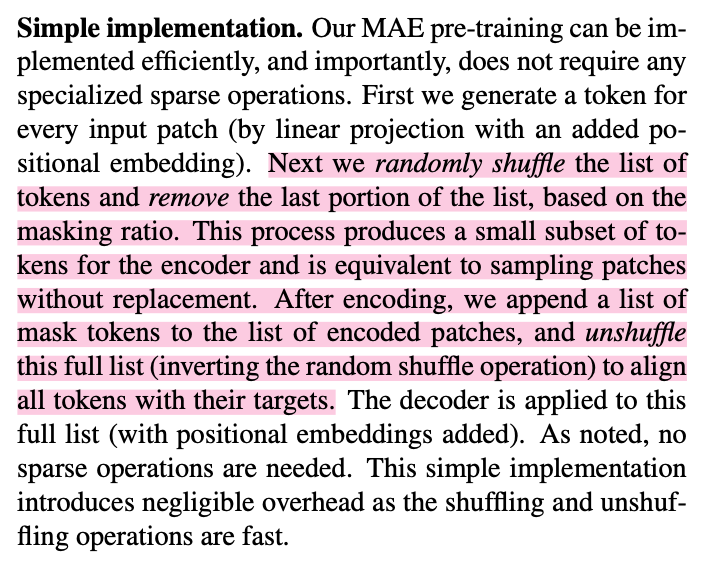

**Your turn**: follow the textual description of the algorithm above as well as the instructions in the following docstring to implement the `random_masking` function.


This function takes the original patched batch of size (N, L, D) as input and returns:

* (a) `patches_kept`: the sequence of non-masked tokens
* (b) `mask`: a binary mask indicating which grid position are masked for every image in the batch
* (c) `ids_restore`: list of indices indicating how to revert the patch shuffling operation used to create the mask.

Hint: the `gather` function in PyTorch could prove handy for this task.

In [ ]:
def random_masking(patches, mask_ratio):
        """
        ### TODO ####
        This function performs the random_masking operation as described in the MAE paper


        Args:
            patches: original patched batch of size (N, L, D)
            mask_ratio: float between 0 and 1, the proportion of patches to mask in each image.

        Returns:
            patches_kept: tensor (N, L_kept, D) the sequence of non-masked patches (shuffled)
            mask: tensor (N, L, D) binary mask indicating which positions are masked (in the original patch grid)
            ids_restore: tensor (N, L) list of indices indicating how to un-shuffle the list of tokens. masked indices maps to -1 while kept indices map to [0, L_kept-1] (maybe)?
        """

        N, L, D = patches.shape  # batch, length, dim

        # Step 1: create noise in [0, 1]
        ### ADD YOUR CODE HERE

        # Step 2: sort noise for each sample
        ### ADD YOUR CODE HERE

        # Step 3: store list of indices to revert shuffling operation later
        ### ADD YOUR CODE HERE

        # Step 4: used shuffled list to keep only a subset of patches
        ### ADD YOUR CODE HERE

        # Step 5 : generate the binary mask
        ### ADD YOUR CODE HERE

        return patches_kept, mask, ids_restore

In [ ]:
patches_kept, mask, ids_restore = random_masking(patches, 0.75)

Check the shapes of our outputs. Are there as expected?

In [ ]:
patches_kept.shape, mask.shape, ids_restore.shape

#### Visualisation of random masking
In this cell, we ask you to use the previously implemented functions `patchify`, `unpatchify` and `random_masking` to visualise the first three images in the validation batch at a masking ratio of 75% and 25%. Create a 2 x 3 subplots grids, the first row should be masked at 75%, the second one at 25%

In [ ]:
patch_size = (4,4)
images, _ = next(iter(datamodule.val_dataloader()))
f, ax = plt.subplots(2, 3, figsize=(15, 8))
image_size = (28, 28)
patches = patchify(images[:3], patch_size)
N, L, D = patches.shape
patches_kept, mask, ids_restore = random_masking(patches, 0.75)
# produce empty masked patches
mask_patchs = torch.zeros(N, L-patches_kept.shape[1], D)
# append mask patches to kept patches
x_ = torch.cat([patches_kept, mask_patchs], dim=1)
patches_masked = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, D))  # unshuffle
# naive method:
# patches_masked = torch.zeros_like(patches)
# for i in range(3):
#     ids = ids_restore[i]
#     m = mask[i]
#     for x in range(4*4):
#         if not m[x]:
#             patches_masked[i, x] = patches_kept[i, ids[x]]
img = unpatchify(patches_masked, patch_size, image_size)
for i in range(3):
    ax[0,i].imshow(img[i, 0], cmap='gray')
    ax[0,i].axis('off')

patches_kept, mask, ids_restore = random_masking(patches, 0.25)
mask_patchs = torch.zeros(N, L-patches_kept.shape[1], D)
x_ = torch.cat([patches_kept, mask_patchs], dim=1)
patches_masked = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, D))
img = unpatchify(patches_masked, patch_size, image_size)
for i in range(3):
    ax[1,i].imshow(img[i, 0], cmap='gray')
    ax[1,i].axis('off')

## **Part C**: Implement and train a full MAE model.

In this part, you will use the previously defined utility functions along with some helper code that we provide to implement the full training pipeline of Masked Auto-Encoder.

We here provide you with all helper functions for defining positional embeddings and for defining the ViT forward passes. You are asked to link all these pieces together by implementing the MAE forward pass and the loss function computation, along with some visualisation function.

In the following, we provide code for creating the positional embeddings for the ViT. You do not need to implement anything here, just run this cell.

In [ ]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

import numpy as np

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    if isinstance(grid_size, int):
        grid_size = (grid_size[0], grid_size[1])
    grid_h = np.arange(grid_size[0], dtype=np.float32)
    grid_w = np.arange(grid_size[1], dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size[0], grid_size[1]])

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    pos_embed = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)

    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

### **Task C-1:** MAE model implementation
We provide you with the main skeleton for the MAE module. The init function defines the main components for you.

You are asked to fill the blanks in the following functions:
  * `patchify`
  * `configure_optimizer`
  * `random_masking`
  * `unpatchify`
  * `compute_loss`
  * `forward`

For each of these functions we give more detailed instructions in the docstring.

When you have finished implementing these functions, move on to the next cells to start training!

In [ ]:
class MaskedAutoencoderViT(LightningModule):
    """
    Skeleton code for MAE with ViT.
    We provide most of the boiler plate code, including the ViT encoder and
    decoder forward passes. You are asked to link the pieces together
    by implementing the pieces of code marked with TODO
    """

    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        embed_dim=1024,
        depth=24,
        num_heads=16,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
    ):
        super().__init__()

        # MAE encoder definition
        self.embed_dim = embed_dim
        self.in_chans = in_chans
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        print(self.patch_embed.grid_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False
        )

        self.blocks = nn.ModuleList(
            [
                Block(
                    embed_dim,
                    num_heads,
                    mlp_ratio,
                    qkv_bias=True,
                    norm_layer=nn.LayerNorm,
                )
                for i in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim)

        # MAE decoder definition
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False
        )

        self.decoder_blocks = nn.ModuleList(
            [
                Block(
                    decoder_embed_dim,
                    decoder_num_heads,
                    mlp_ratio,
                    qkv_bias=True,
                    norm_layer=nn.LayerNorm,
                )
                for i in range(decoder_depth)
            ]
        )

        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        self.decoder_pred = nn.Linear(
            decoder_embed_dim, patch_size**2 * in_chans, bias=True
        )

        # Positional embeddings
        pos_embed = get_2d_sincos_pos_embed(
            embed_dim=self.pos_embed.shape[-1],
            grid_size=self.patch_embed.grid_size,
            cls_token=True,
        )
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(
            self.decoder_pos_embed.shape[-1],
            grid_size=self.patch_embed.grid_size,
            cls_token=True,
        )
        self.decoder_pos_embed.data.copy_(
            torch.from_numpy(decoder_pos_embed).float().unsqueeze(0)
        )


    def patchify(self, imgs):
        """
        imgs: (N, C, H, W)
        x: (N, L, patch_size**2 *3)
        """
        return patchify(imgs, self.patch_embed.patch_size)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        return unpatchify(x, self.patch_embed.patch_size, self.patch_embed.img_size, self.in_chans)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        return random_masking(x, mask_ratio)

    def forward_encoder(self, x, mask_ratio):
        """
        Forward function for the encoding part.
        """
        # embed patches (use self.patch_embed)
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        """
        Forward function for the decoding part.
        """
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(
            x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1
        )
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(
            x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2])
        )  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def compute_loss(self, target_patches, pred_patches, mask):
        """
        This function returns the MAE loss value for a given batch.
        Should be MSE loss over masked patches
        Args:
          target_patches: [N, C, H, W] ground truth patches
          pred_patches: [N, L, p*p*C] predicted patches
          mask: [N, L] binary mask indicating which patches are masked
        """
        patches = self.patchify(target_patches)
        target = torch.masked_select(patches, mask)
        pred = torch.masked_select(pred_patches, mask)
        return torch.nn.functional.mse_loss(pred, target)

    def forward(self, imgs, mask_ratio=0.75):
        """
        Forward function
        Args:
          imgs: batch of [N, C, H, W] images
          mask_ratio: masking ratio to use for the encoder

        Returns:
          predicted_patches [N, L, D], where D = patch_size[0]*patch_size[1]*C
          mask [N, L]
        """
        patches = self.patchify(imgs)
        x, mask, ids_restore = self.forward_encoder(patches, mask_ratio)
        pred_patches = self.forward_decoder(x, ids_restore)
        return pred_patches, mask

    def training_step(self, batch, batch_idx):
        images = batch[0]
        predicted_patches, mask = self(images)
        target_patches = self.patchify(images)
        loss = self.compute_loss(target_patches, predicted_patches, mask)
        self.log('loss_train', loss, prog_bar=True)

        if batch_idx == 0:
            images_output = self.unpatchify(predicted_patches * mask.unsqueeze(2) + target_patches * (~mask.bool()).int().unsqueeze(2))
            grid = torchvision.utils.make_grid(images[0:4], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images_input', grid, self.global_step)
            grid = torchvision.utils.make_grid(images_output[0:4], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images_output', grid, self.global_step)
            grid = torchvision.utils.make_grid(self.unpatchify(target_patches * mask.unsqueeze(2))[0:4], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_patches_target', grid, self.global_step)
            grid_predicted = torchvision.utils.make_grid(self.unpatchify(predicted_patches * mask.unsqueeze(2))[0:4], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_patches_predicted', grid_predicted, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch[0]
        predicted_patches, mask = self(batch[0])
        target_patches = self.patchify(images)
        loss = self.compute_loss(target_patches, predicted_patches, mask)

        self.log('loss_val', loss, prog_bar=True)

    def get_class_embeddings(self, images):
        """
        Return the class embeddings extracted from the encoder
        for each image in the batch.
        This function is meant to be used at inference, we do not mask
        any patches.
        """
        embeddings, _, _ = self.forward_encoder(images, mask_ratio=0)
        return embeddings[:, 0, :]

    def predict_step(self, batch, batch_idx):
        images, labels = batch[0], batch[1]
        return {'embeddings': self.get_class_embeddings(images), 'labels': labels}

Next, we define a tiny toy VIT architecture for you to use in this coursework. This is much smaller than standard ViT architectures but will allow you to train your MAE rapidly on a single GPU. Note that we use again a patch size of 4 given the small resolution of the input images.

In [ ]:
def mae_vit_toy_patch4_dec256d4b():
    """
    Creates a toy ViT with patch size 4.
    """
    model = MaskedAutoencoderViT(
        in_chans=1,
        img_size=28,
        patch_size=4,
        embed_dim=384,
        depth=6,
        num_heads=6,
        decoder_embed_dim=256,
        decoder_depth=4,
        decoder_num_heads=8,
        mlp_ratio=4,
    )
    return model

### **Task C-2:** MAE training

#### Tensorboard logging
Load tensorboard, you should be able to monitor training and validation loss as well as your reconstructed training images.

**IMPORTANT** keep the output of the cell, your submitted notebook should show tensorbard as well!

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir './lightning_logs/coursework/'

We provide the training code, just run this cell and wait...

In [ ]:
seed_everything(33, workers=True)

data = PneumoniaMNISTDataModule(batch_size=32)

model = mae_vit_toy_patch4_dec256d4b()

trainer = Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/coursework/', name='mae_test'),
)
trainer.fit(model=model, datamodule=data)

## **Part D**: Inspect the trained model.

In this last part, we ask you to analyse the feature embeddings (or representations) obtained from your trained model with t-SNE, similar to the tutorial on model inspection. Let's see if your model learned anything useful!

### **Task D-1:** Inspect and compare the learned feature representations of your trained model.

Compare the feature embeddings of your trained model to embeddings obtained with a randomly initialised (untrained) model. Create some scatter plot visualisations and describe your findings with a few sentences.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

Let's get the representations from our trained model:

Let's compare with the representation of an untrained model

Summarise your observations...